In [1]:
!pip install category_encoders

In [2]:
!pip install eli5

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, validation_curve
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import category_encoders as ce
import eli5
from eli5.sklearn import PermutationImportance


# In order to see all of the columns of the dataset we need to set the display options
# from the Pandas package to at least 100 (the dataset has 96 columns) and, for the rows,
# I set it to at least 100 which will help when I check for null values and dtypes.

pd.set_option('mode.chained_assignment', None) # Everytime I made a new column I would have a warning raised
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
# Importing the CSV 'listings_summary.csv' from the Kaggle dataset found at this
# URL: https://www.kaggle.com/brittabettendorf/berlin-airbnb-data

listings_summary = pd.read_csv('https://raw.githubusercontent.com/BuildWeekAirbnbOptimal2/Datascience/master/Berlin.csv')

In [5]:
# As stated above, there are 96 columns and over 20,000 observations

listings_summary.shape

(22552, 96)

In [6]:
# Checking the dtypes of the dataset...

# The goal of this project is to find the optimal price for an AirBnB in Belin, Germany so,
# the target variable will be the 'price' which is currently an object and therefore, will
# have to be dealt with appropriately.

listings_summary.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
summary                              object
space                                object
description                          object
experiences_offered                  object
neighborhood_overview                object
notes                                object
transit                              object
access                               object
interaction                          object
house_rules                          object
thumbnail_url                       float64
medium_url                          float64
picture_url                          object
xl_picture_url                      float64
host_id                               int64
host_url                             object
host_name                            object
host_since                      

In [7]:
# Next we will check for the null values within the dataset - there are quite a few...

listings_summary.isna().sum()

id                                      0
listing_url                             0
scrape_id                               0
last_scraped                            0
name                                   59
summary                               963
space                                8532
description                           203
experiences_offered                     0
neighborhood_overview               11012
notes                               15337
transit                              9516
access                              11715
interaction                         12146
house_rules                         11103
thumbnail_url                       22552
medium_url                          22552
picture_url                             0
xl_picture_url                      22552
host_id                                 0
host_url                                0
host_name                              26
host_since                             26
host_location                     

In [8]:
# Calling the head of the dataset to visualize what the first row of observations looks like

listings_summary.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,96%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,3 months ago,t,0,21,51,141,2018-11-07,118,2016-04-11,2018-10-28,93.0,10.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76


In [9]:
# We can already tell later on we will have to drop a few columns where the cardinality for some
# object features, while finite, will be very high epecially in the case of URLs, names, reviews,
# descriptions, etc. so we will remove a few of them now and possibly later.

In [10]:
# First, we will use a for loop to check the number of unique values in each column.  This is acheived
# by taking the length of the value_counts of a column.

for col in listings_summary:
    print(f'There are/is {len(listings_summary[col].value_counts())} unique value(s) for column: {col}') if listings_summary[col].dtypes=='O' else print(None)

None
There are/is 22552 unique value(s) for column: listing_url
None
There are/is 2 unique value(s) for column: last_scraped
There are/is 21873 unique value(s) for column: name
There are/is 21041 unique value(s) for column: summary
There are/is 13598 unique value(s) for column: space
There are/is 21997 unique value(s) for column: description
There are/is 1 unique value(s) for column: experiences_offered
There are/is 10781 unique value(s) for column: neighborhood_overview
There are/is 6687 unique value(s) for column: notes
There are/is 12308 unique value(s) for column: transit
There are/is 9946 unique value(s) for column: access
There are/is 9584 unique value(s) for column: interaction
There are/is 10350 unique value(s) for column: house_rules
None
None
There are/is 22465 unique value(s) for column: picture_url
None
None
There are/is 19180 unique value(s) for column: host_url
There are/is 5997 unique value(s) for column: host_name
There are/is 2914 unique value(s) for column: host_since

In [11]:
listings_summary.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,96%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,3 months ago,t,0,21,51,141,2018-11-07,118,2016-04-11,2018-10-28,93.0,10.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76


In [12]:
# The first thing we will do is remove the object columns with high cardinality and features that are probably
# redundant like 'city' since this is the Berlin AirBnB dataset - 'zipcode' may be useful but neighbourhood could
# cover that.

high_cardin = ['listing_url', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview',
               'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
               'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url',
               'host_picture_url', 'host_verifications', 'street', 'city', 'state', 'zipcode', 'market',
               'smart_location', 'country_code', 'country', 'bed_type', 'amenities', 'weekly_price', 'monthly_price',
               'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'is_business_travel_ready',
               'require_guest_profile_picture', 'require_guest_phone_verification']

In [13]:
listings_df = listings_summary.drop(columns=high_cardin)

In [14]:
listings_df.isna().sum()

id                                    0
scrape_id                             0
last_scraped                          0
host_id                               0
host_since                           26
host_location                       116
host_response_time                12894
host_response_rate                12895
host_acceptance_rate              22552
host_is_superhost                    26
host_neighbourhood                 5094
host_listings_count                  26
host_total_listings_count            26
host_has_profile_pic                 26
host_identity_verified               26
neighbourhood                      1131
neighbourhood_cleansed                0
neighbourhood_group_cleansed          0
latitude                              0
longitude                             0
is_location_exact                     0
property_type                         0
room_type                             0
accommodates                          0
bathrooms                            32


In [15]:
# We will also remove columns that have many NaN values

high_na = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'square_feet', 'jurisdiction_names']

Berlin_airbnb = listings_df.drop(columns=high_na)

In [16]:
Berlin_airbnb.dtypes

id                                  int64
scrape_id                           int64
last_scraped                       object
host_id                             int64
host_since                         object
host_location                      object
host_is_superhost                  object
host_neighbourhood                 object
host_listings_count               float64
host_total_listings_count         float64
host_has_profile_pic               object
host_identity_verified             object
neighbourhood                      object
neighbourhood_cleansed             object
neighbourhood_group_cleansed       object
latitude                          float64
longitude                         float64
is_location_exact                  object
property_type                      object
room_type                          object
accommodates                        int64
bathrooms                         float64
bedrooms                          float64
beds                              

In [17]:
# Next we will engineer some features based on the data

In [18]:
# Originally, the 'security_deposit' column would've been kept and replaced NaN values with the mean but,
# Since there are many NaN values we will make a binary feature stating '1' if they require a security deposit
# and '0' if the do not require one.


# TODO: drop Berlin_airbnb['security_deposit']
has_security_dep = []
for i in Berlin_airbnb['security_deposit']:
    if i==np.NaN:
        has_security_dep.append(0)
    else:
        has_security_dep.append(1)
Berlin_airbnb['require_security_deposit'] = np.array(has_security_dep).astype(int)

In [19]:
# We will do the same with cleaning fee and call it 'has_cleaning_service'...

# TODO: drop Berlin_airbnb['cleaning_fee']
has_cleaning = []
for i in Berlin_airbnb['cleaning_fee']:
    if i==np.NaN:
        has_cleaning.append(0)
    else:
        has_cleaning.append(1)
Berlin_airbnb['has_cleaning_service'] = np.array(has_cleaning).astype(int)

In [20]:
# Possible columns to impute or use for feature engineering

# review_scores_rating - mode = 100.00 (46 unique values between 50.00 and 100.00)
# review_scores_accuracy - mode = 10.0 (more than 50% of the data)
# review_scores_cleanliness - mode = 10.0
# review_scores_checkin - mode = 10.0 (more than 50% of the data)
# review_scores_communication - mode = 10.0 (more than 50% of the data)
# review_scores_location - mode = 10.0
# review_scores_value - mode = 10.0

In [21]:
# Next, we will get rid of the dollar signs and any commas that may be contained in the 'price'
# and 'extra_people' column by making a function that will strip the dollar sign ('$') from the
# array, remove the redundant '.00', and then remove commas for amounts 1000 or larger

def dollar_to_int(row):
    return row.strip('$')[:-3]
def no_comma(row):
    return row.replace(',','')

# To show it works...

amount = dollar_to_int('$1,300.00')
print(no_comma(amount))

1300


In [22]:
# Applying them to the dataset...

Berlin_airbnb['price'] = Berlin_airbnb['price'].apply(dollar_to_int).apply(no_comma).astype(int)
Berlin_airbnb['extra_people'] = Berlin_airbnb['extra_people'].apply(dollar_to_int).apply(no_comma).astype(int)

In [23]:
Berlin_airbnb.shape

(22552, 52)

In [24]:
Berlin_airbnb = Berlin_airbnb.drop(columns=['security_deposit', 'cleaning_fee'])

In [25]:
# 'property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'bed_type','price','number_of_reviews',('review_scores_value '),'instant_bookable','cancellation_policy','neighbourhood','host_identity_verified'

In [26]:
# Possibly useful: - Predicting 'PRICE'
# 1. neighbourhood
# 2. property type
# 3. room type
# 4. accommodates
# 5. bathrooms
# 6. bedrooms
# 7. beds
# 8. reviews_scores_value
# 9. instant_bookable
# 10. cancellation_policy
# 10. has_cleaning_service

### Columns we may go with
# 'property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'bed_type','price','number_of_reviews',('review_scores_value '),'instant_bookable','cancellation_policy','neighbourhood','host_identity_verified'

In [27]:
Berlin_subset = Berlin_airbnb[['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
                               'price', 'number_of_reviews', 'review_scores_value', 'instant_bookable',
                               'cancellation_policy', 'neighbourhood', 'host_identity_verified']]
Berlin_subset.head()

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_value,instant_bookable,cancellation_policy,neighbourhood,host_identity_verified
0,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,60,118,9.0,f,strict_14_with_grace_period,Mitte,t
1,Apartment,Private room,2,1.0,1.0,1.0,17,6,10.0,f,flexible,NaN,t
2,Apartment,Entire home/apt,4,1.0,1.0,2.0,90,143,9.0,t,strict_14_with_grace_period,Prenzlauer Berg,t
3,Apartment,Private room,2,1.0,1.0,1.0,26,25,9.0,f,strict_14_with_grace_period,Schöneberg,t
4,Apartment,Private room,2,1.0,1.0,2.0,42,197,9.0,f,moderate,Prenzlauer Berg,t


In [28]:
###### We need to include why we are using these columns!! ######

# i.e. Why we chose to condense 'accommodates'

In [29]:
Berlin_subset.dtypes

property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
price                       int32
number_of_reviews           int64
review_scores_value       float64
instant_bookable           object
cancellation_policy        object
neighbourhood              object
host_identity_verified     object
dtype: object

In [30]:
Berlin_subset['accommodates'].value_counts()

2     12228
4      3216
1      2734
3      2487
6       733
5       701
8       151
7       131
10       57
9        36
12       24
16       20
11       15
14       11
15        6
13        2
Name: accommodates, dtype: int64

In [31]:
# Minimizing the values for the accommodates column
# We will make them objects from 1-6 and then 7+

accommodate = []
for int in Berlin_subset['accommodates']:
    if int==1:
        accommodate.append('1')
    elif int==2:
        accommodate.append('2')
    elif int==3:
        accommodate.append('3')
    elif int==4:
        accommodate.append('4')
    elif int==5:
        accommodate.append('5')
    elif int==6:
        accommodate.append('6')
    elif int>=7:
        accommodate.append('7+')
    else:
        accommodate.append('')
set(accommodate)

{'1', '2', '3', '4', '5', '6', '7+'}

In [32]:
Berlin_subset['can_accommodate'] = np.array(accommodate)

In [33]:
bedrooms = []
for bed in Berlin_subset['bedrooms']:
    if bed==1.0:
        bedrooms.append('1')
    else:
        bedrooms.append('2+')
set(bedrooms)

{'1', '2+'}

In [34]:
Berlin_subset['n_bedrooms'] = np.array(bedrooms)

In [35]:
bathrooms = []
for bath in Berlin_subset['bathrooms']:
    if bath==1.0:
        bathrooms.append('1')
    else:
        bathrooms.append('2+')
set(bathrooms)

{'1', '2+'}

In [36]:
Berlin_subset['n_bathrooms'] = np.array(bathrooms)

In [37]:
beds = []
for bed in Berlin_subset['beds']:
    if bed==1.0:
        beds.append('1')
    else:
        beds.append('2+')
set(beds)

{'1', '2+'}

In [38]:
Berlin_subset['n_beds'] = np.array(beds)

In [39]:
def to_nbool(array):
    for i in array:
        if i=='t':
            return 1
        else:
            return 0

In [40]:
Berlin_subset['host_identity_verified'] = Berlin_subset['host_identity_verified'].dropna().apply(to_nbool)

In [41]:
Berlin_subset['instant_bookable'] = Berlin_subset['instant_bookable'].dropna().apply(to_nbool)

In [42]:
Berlin_subset['review_scores_value'] = Berlin_subset['review_scores_value'].replace(np.NaN, 0)

In [43]:
scores = []
for rating in Berlin_subset['review_scores_value']:
    if rating>=7.0:
        scores.append(rating)
    else:
        scores.append(0.0)
set(scores)

{0.0, 7.0, 8.0, 9.0, 10.0}

In [44]:
Berlin_subset['review_score'] = scores

In [45]:
Berlin = Berlin_subset.drop(columns=['accommodates', 'bathrooms', 'bedrooms',
                                    'beds', 'review_scores_value'])

In [46]:
Berlin.shape

(22552, 13)

In [47]:
Berlin.head()

,property_type,room_type,price,number_of_reviews,instant_bookable,cancellation_policy,neighbourhood,host_identity_verified,can_accommodate,n_bedrooms,n_bathrooms,n_beds,review_score
0,Guesthouse,Entire home/apt,60,118,0,strict_14_with_grace_period,Mitte,1.0,3,1,1,2+,9.0
1,Apartment,Private room,17,6,0,flexible,NaN,1.0,2,1,1,1,10.0
2,Apartment,Entire home/apt,90,143,1,strict_14_with_grace_period,Prenzlauer Berg,1.0,4,1,1,2+,9.0
3,Apartment,Private room,26,25,0,strict_14_with_grace_period,Schöneberg,1.0,2,1,1,1,9.0
4,Apartment,Private room,42,197,0,moderate,Prenzlauer Berg,1.0,2,1,1,2+,9.0


In [48]:
# Instead of reassigning these values to 'cancellation_policy' we will keep the original just in case we need it back

Berlin['cancel_policy'] = Berlin['cancellation_policy'].replace(('super_strict_30', 'super_strict_60', 'strict_14_with_grace_period'),'strict')

In [49]:
len(Berlin.columns)

14

In [50]:
Berlin.isnull().sum()

property_type                0
room_type                    0
price                        0
number_of_reviews            0
instant_bookable             0
cancellation_policy          0
neighbourhood             1131
host_identity_verified      26
can_accommodate              0
n_bedrooms                   0
n_bathrooms                  0
n_beds                       0
review_score                 0
cancel_policy                0
dtype: int64

In [53]:
Berlin['neighbourhood'] = Berlin['neighbourhood'].replace(np.NaN, 'TODO')

In [55]:
Berlin['neighbourhood'].value_counts()

Neukölln                3209
Prenzlauer Berg         2768
Kreuzberg               2661
Friedrichshain          2526
Mitte                   1943
Wedding                 1417
TODO                    1131
Schöneberg              1065
Moabit                   778
Charlottenburg           767
Wilmersdorf              483
Pankow                   281
Tempelhof                254
Rummelsburg              248
Weißensee                195
Lichtenberg              174
Tiergarten               163
Alt-Treptow              156
Steglitz                 153
Reinickendorf            139
Westend                  117
Friedenau                 96
Lichterfelde              92
Baumschulenweg            82
Zehlendorf                82
Friedrichsfelde           68
Britz                     61
Halensee                  60
Niederschönhausen         59
Fennpfuhl                 56
Potsdamer Platz           53
Karlshorst                52
Plänterwald               52
Köpenick                  51
Alt-Hohenschön

In [57]:
# Something we could do is split these neighbourhoods into North, South, East, and West Berlin.
# There are also 12 boroughs in Berlin that could be used.
# All in the name of Data Science........

boroughs = []
for boro in Berlin['neighbourhood']:
    
    Charlot = ['Charlottenburg-Nord', 'Schmargendorf', 'Grunewald', 'Halensee', 'Westend', 'Wilmersdorf', 'Charlottenburg']
    Fried = ['Kreuzberg', 'Friedrichshain']
    Licht = ['Falkenberg', 'Neu-Hohenschönhausen', 'Alt-Hohenschönhausen', 'Karlshorst', 'Fennpfuhl', 'Friedrichsfelde',
             'Lichtenberg', 'Rummelsburg']
    Marzahn = ['Kaulsdorf', 'Hellersdorf', 'Mahlsdorf', 'Biesdorf', 'Marzahn']
    Mitte = ['Hansaviertel', 'Potsdamer Platz', 'Tiergarten', 'Moabit', 'Wedding', 'Mitte']
    Neukolln = ['Gropuisstadt', 'Buckow', 'Rudow', 'Britz', 'Neukölln']
    Pankow = ['Rosenthal', 'Wilhelmsruh', 'Blankenburg', 'Heinersdorf', 'Buch', 'Karow', 'Französisch Buchholz',
              'Niederschönhausen', 'Weißensee', 'Pankow', 'Prenzlauer Berg']
    Reinick = ['Lübars', 'Konradshöhe', 'Waidmannslust', 'Märkisches Viertel', 'Heiligesee', 'Hermsdorf', 'Frohnau',
               'Wittenau', 'Tegel', 'Reinickendorf']
    Spandau = ['Haselhorst', 'Gatow', 'Falkenhagener', 'Siemensstadt', 'Staaken', 'Hakenfelde', 'Kladow',
               'Wilhelmstadt', 'Spandau']
    Steglitz = ['Wansee', 'Dahlem', 'Nikolassee', 'Lankwitz', 'Zehlendorf', 'Lichterfelde', 'Steglitz']
    Tempelhof = ['Marienfelde', 'Lichtenrade', 'Mariendorf', 'Friedenau', 'Tempelhof', 'Schöneberg']
    Treptow = ['Müggelheim', 'Bohnsdorf', 'Grünau', 'Schmökewite', 'Niederschöneweide', 'Altglienicke',
               'Johannesthal', 'Friedrichshagen', 'Adlershof', 'Rahnsdorf', 'Oberschöneweide',
               'Köpenick', 'Plänterwald', 'Baumschulenweg', 'Alt-Treptow']
    
    if boro in Charlot:
        boroughs.append('Charlottenburg-Wilmersdorf')
    elif boro in Fried:
        boroughs.append('Friedrichshain-Kreuzberg')
    elif boro in Licht:
        boroughs.append('Lichtenberg')
    elif boro in Marzahn:
        boroughs.append('Marzahn-Hellersdorf')
    elif boro in Mitte:
        boroughs.append('Mitte')
    elif boro in Neukolln:
        boroughs.append('Neukölln')
    elif boro in Pankow:
        boroughs.append('Pankow')
    elif boro in Reinick:
        boroughs.append('Reinickendorf')
    elif boro in Spandau:
        boroughs.append('Spandau')
    elif boro in Steglitz:
        boroughs.append('Steglitz-Zehlendorf')
    elif boro in Tempelhof:
        boroughs.append('Tempelhof-Schöneberg')
    elif boro in Treptow:
        boroughs.append('Treptow-Köpernick')
    else:
        boroughs.append('TODO')
set(boroughs)

{'Charlottenburg-Wilmersdorf',
 'Friedrichshain-Kreuzberg',
 'Lichtenberg',
 'Marzahn-Hellersdorf',
 'Mitte',
 'Neukölln',
 'Pankow',
 'Reinickendorf',
 'Spandau',
 'Steglitz-Zehlendorf',
 'TODO',
 'Tempelhof-Schöneberg',
 'Treptow-Köpernick'}

In [60]:
Berlin['boroughs'] = boroughs

AttributeError: 'Series' object has no attribute 'med'

In [63]:
Berlin['boroughs'] = Berlin['boroughs'].replace('TODO', np.NaN)

In [64]:
Berlin['host_identity_verified'].dtypes

dtype('float64')

In [65]:
# For 'host_identity_verified', it would make sense to fill the NA values with 0 (FALSE)
# We will also convert the column from float to integers(int64)

Berlin['host_identity_verified'] = Berlin['host_identity_verified'].replace(np.NaN, 0).astype('int64')

In [66]:
# Saving this column for backup

Berlin_cancel = Berlin['cancellation_policy']

In [67]:
Berlin.columns

Index(['property_type', 'room_type', 'price', 'number_of_reviews',
       'instant_bookable', 'cancellation_policy', 'neighbourhood',
       'host_identity_verified', 'can_accommodate', 'n_bedrooms',
       'n_bathrooms', 'n_beds', 'review_score', 'cancel_policy', 'boroughs'],
      dtype='object')

In [68]:
# Reassigning the Berlin dataframe to the columns we are checking out
#  'neighbourhood',

Berlin = Berlin[['property_type', 'room_type', 'price', 'number_of_reviews',
                 'instant_bookable', 'boroughs', 'host_identity_verified',
                 'can_accommodate', 'n_bedrooms', 'n_bathrooms', 'n_beds',
                 'review_score', 'cancel_policy']]

In [69]:
Berlin.head()

,property_type,room_type,price,number_of_reviews,instant_bookable,boroughs,host_identity_verified,can_accommodate,n_bedrooms,n_bathrooms,n_beds,review_score,cancel_policy
0,Guesthouse,Entire home/apt,60,118,0,Mitte,1,3,1,1,2+,9.0,strict
1,Apartment,Private room,17,6,0,NaN,1,2,1,1,1,10.0,flexible
2,Apartment,Entire home/apt,90,143,1,Pankow,1,4,1,1,2+,9.0,strict
3,Apartment,Private room,26,25,0,Tempelhof-Schöneberg,1,2,1,1,1,9.0,strict
4,Apartment,Private room,42,197,0,Pankow,1,2,1,1,2+,9.0,moderate


In [71]:
Berlin.isna().sum()

property_type                0
room_type                    0
price                        0
number_of_reviews            0
instant_bookable             0
boroughs                  1218
host_identity_verified       0
can_accommodate              0
n_bedrooms                   0
n_bathrooms                  0
n_beds                       0
review_score                 0
cancel_policy                0
dtype: int64

In [73]:
non_na = Berlin[Berlin['boroughs'].notna()]
non_na.shape

(21334, 13)

In [74]:
# Ofer work starting here (James' notes between two asterisks **)

# Create Train/**Val/**Test **Incorporating random_state for reproducibility**
# **If we have time, we may want to try different values for test_size**

train, test = train_test_split(non_na, train_size=0.80, test_size=0.20, random_state=42)
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)

for df in train, val, test:
    print(df.shape)

(13653, 13)
(3414, 13)
(4267, 13)


In [76]:
# **Splitting up features and target then, X_train, y_train, etc.**
# 'neighbourhood',

features = ['property_type', 'room_type', 'number_of_reviews',
            'instant_bookable', 'boroughs', 'host_identity_verified',
            'can_accommodate', 'n_bedrooms', 'n_bathrooms', 'n_beds',
            'review_score', 'cancel_policy']
target = 'price'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [77]:
# **Taking a baseline using 0 features and the mean of the target('price') column**
# How far off would we be if we used this average?

# Arrange y target vectors - target already assigned in cell above
y_train_mae = train[target]
y_val_mae = val[target]
y_test_mae = test[target]

print(f'Mean Baseline (using 0 features) and Price mean of: {round(y_train_mae.mean())}')
guess = round(y_train.mean()) # **so that the mean is an integer**

# Train Error
y_pred = [guess] * len(y_train_mae)
mae = mean_absolute_error(y_train_mae, y_pred)
print(f'Train Error for Berlin: {mae:.2f} percentage points')

# Validate Error
y_pred = [guess] * len(y_val_mae)
mae = mean_absolute_error(y_val_mae, y_pred)
print(f'Train Error for Berlin: {mae:.2f} percentage points')

# Test Error
y_pred = [guess] * len(y_test_mae)
mae = mean_absolute_error(y_test_mae, y_pred)
print(f'Test Error for Berlin: {mae:.2f} percentage points')

Mean Baseline (using 0 features) and Price mean of: 67
Train Error for Berlin: 40.78 percentage points
Train Error for Berlin: 41.35 percentage points
Test Error for Berlin: 44.41 percentage points


In [78]:
# Encoding the categorical features using Ordinal Encoder which will start at 1
# for the first unique string and then count +1 for each new unique string

encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.fit_transform(X_val)
X_test_encoded = encoder.fit_transform(X_test)

# To see what we did...
X_train_encoded.head()

,property_type,room_type,number_of_reviews,instant_bookable,boroughs,host_identity_verified,can_accommodate,n_bedrooms,n_bathrooms,n_beds,review_score,cancel_policy
13493,1,1,0,1,1,0,1,1,1,1,0.0,1
4508,1,2,6,1,1,0,2,2,1,1,10.0,2
1914,1,1,29,0,2,0,3,1,1,2,10.0,2
20128,1,2,19,1,3,0,2,2,1,1,9.0,3
13536,2,1,12,0,1,1,2,2,1,1,9.0,3


In [79]:
# Now check the data types...
X_train_encoded.dtypes

property_type               int32
room_type                   int32
number_of_reviews           int64
instant_bookable            int64
boroughs                    int32
host_identity_verified      int64
can_accommodate             int32
n_bedrooms                  int32
n_bathrooms                 int32
n_beds                      int32
review_score              float64
cancel_policy               int32
dtype: object

In [80]:
# **Making a function which will test the numeric features indivudually using LinearRegression**

model = LinearRegression()

def lr_feature_error(array):
    
    # Arranging X features matrices (already did y target vectors)
    X_train_lr = X_train_encoded[array].values.reshape(-1, 1)
    print(f'Linear Regression, dependent on: {array}')

    # Fit the model
    model.fit(X_train_lr, y_train)
    y_pred = model.predict(X_train_lr)
    mae = mean_absolute_error(y_train, y_pred)
    print(f'Train Error: {mae:.2f} percentage points \n')

In [81]:
for col in X_train_encoded:
    lr_feature_error(col)

Linear Regression, dependent on: property_type
Train Error: 41.02 percentage points 

Linear Regression, dependent on: room_type
Train Error: 36.52 percentage points 

Linear Regression, dependent on: number_of_reviews
Train Error: 40.63 percentage points 

Linear Regression, dependent on: instant_bookable
Train Error: 41.01 percentage points 

Linear Regression, dependent on: boroughs
Train Error: 40.63 percentage points 

Linear Regression, dependent on: host_identity_verified
Train Error: 40.87 percentage points 

Linear Regression, dependent on: can_accommodate
Train Error: 35.19 percentage points 

Linear Regression, dependent on: n_bedrooms
Train Error: 37.77 percentage points 

Linear Regression, dependent on: n_bathrooms
Train Error: 39.93 percentage points 

Linear Regression, dependent on: n_beds
Train Error: 37.76 percentage points 

Linear Regression, dependent on: review_score
Train Error: 40.99 percentage points 

Linear Regression, dependent on: cancel_policy
Train Error

In [82]:
# **Getting the intercepts**

# Fit the model to the data
model.fit(X_train_encoded, y_train)

# Intercepts and coefficients
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept 67.80844902435052
property_type             10.212104
room_type                -17.282014
number_of_reviews         -0.034188
instant_bookable          16.431831
boroughs                  -1.217888
host_identity_verified    -2.748301
can_accommodate           11.422485
n_bedrooms                -7.179923
n_bathrooms               19.496378
n_beds                    -7.179086
review_score              -1.604035
cancel_policy             -3.219288


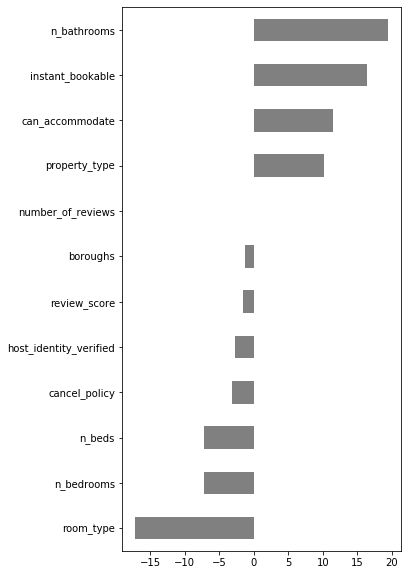

In [83]:
# Plotting these coefficients
coefficients = pd.Series(model.coef_, X_train_encoded.columns)
plt.figure(figsize=(5,10))
coefficients.sort_values().plot.barh(color='grey');

In [84]:
# **TL:DR  - Mainly for originally numeric columns**
# **For the Positive features, as the feature increases, so does the Price**
# **For the Negative features, as the feature decreases, so does the Price**

In [85]:
# Trying some ordinal encoding and LinearRegression() through a pipeline (sklearn.pipeline.make_pipeline)
# Ordinal Encoder will take string values, start at 1 and then count up for each new unique value
# After that we will standardize the data so they can be comparable

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    LinearRegression()
)
pipeline.fit(X_train, y_train)

# # The code below will get coefficients for LinearRegression()

lr = pipeline.named_steps['linearregression']
importances_lr = pd.Series(lr.coef_, X_train.columns)

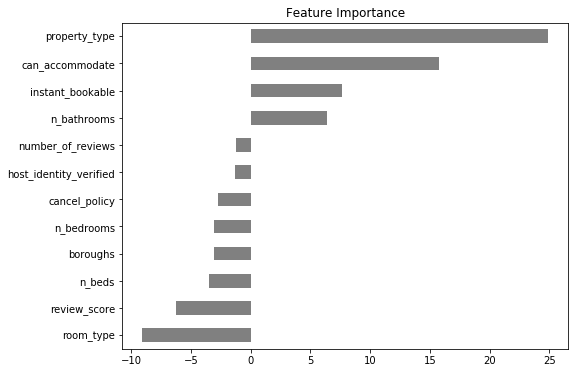

In [86]:
# Plot of the scaled coefficients

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
importances_lr.sort_values().plot.barh(color='grey');

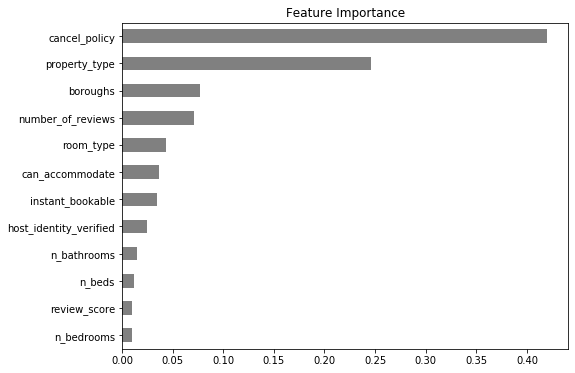

In [87]:
# Lets try a RandomForestRegressor!

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=42)
)
pipeline.fit(X_train, y_train)

# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
importances.sort_values().plot.barh(color='grey');

In [88]:
# Fit on train, score on test
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

rf = pipeline.named_steps['randomforestregressor']

# Print Results
print('Training R^2', pipeline.score(X_train, y_train))
print(f'Training MAE: {mean_absolute_error(y_train, y_pred_train)} dollars')
print('Validation R^2', pipeline.score(X_val, y_val))
print(f'Validation MAE: {mean_absolute_error(y_val, y_pred_val)} dollars')
print('Test R^2', pipeline.score(X_test, y_test))
print(f'Test MAE: {mean_absolute_error(y_test, y_pred_test)} dollars')

Training R^2 0.896684691600207
Training MAE: 13.489958394721006 dollars
Validation R^2 0.7369081855838353
Validation MAE: 28.939108173788462 dollars
Test R^2 0.4425147018366213
Test MAE: 32.015518703620764 dollars


In [89]:
# Cross_val_score with SelectKBest

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    SelectKBest(f_regression, k='all'),
    Ridge()
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                          scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print('Mean score', -scores.mean())

MAE for 3 folds: [37.68399525 35.39090565 36.98231246]
Mean score 36.68573778775866


In [90]:
# With RandomForestRegressor - The MAE is lower when using TargetEncoder

pipeline = make_pipeline(
#     ce.OrdinalEncoder(),
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1),
#     StandardScaler(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                          scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print('Mean score', -scores.mean())

MAE for 3 folds: [33.17680905 27.84444541 31.66267007]
Mean score 30.894641510978545


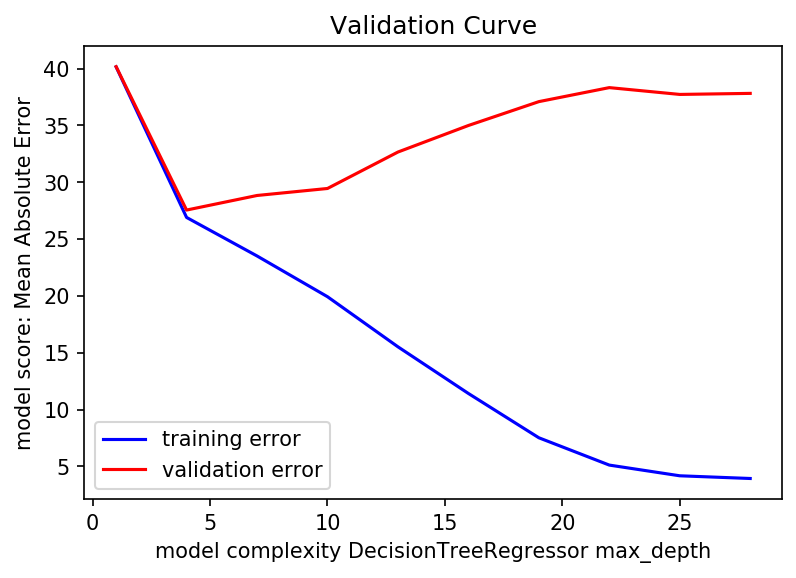

In [91]:
pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1),
    DecisionTreeRegressor()
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='decisiontreeregressor__max_depth',
    param_range=depth, scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity DecisionTreeRegressor max_depth')
plt.ylabel('model score: Mean Absolute Error')
plt.legend()
plt.show()

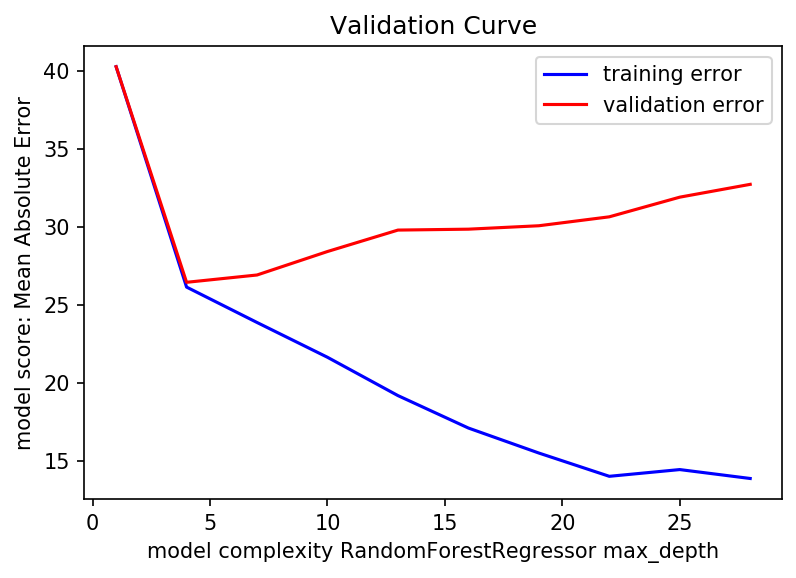

In [92]:
pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1),
    RandomForestRegressor()
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='randomforestregressor__max_depth',
    param_range=depth, scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity RandomForestRegressor max_depth')
plt.ylabel('model score: Mean Absolute Error')
plt.legend()
plt.show()

In [95]:
# Randomized Search with multiple parameter distributions

pipeline = make_pipeline(
    ce.TargetEncoder(),
    RandomForestRegressor()
)

param_distributions = {
    'targetencoder__min_samples_leaf': stats.randint(1, 1000),
    'targetencoder__min_samples_leaf': stats.uniform(1, 1000),
    'randomforestregressor__n_estimators': stats.randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__max_features': stats.uniform(0,1)
}

In [96]:
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.8s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('targetencoder',
                                              TargetEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            min_samples_leaf=1,
                                                            return_df=True,
                                                            smoothing=1.0,
                                                            verbose=0)),
                                             ('randomforestregressor',
                                              RandomForestRegressor(bootstrap=True,
                                                

In [97]:
print('Best hyperparameters:', search.best_params_)
print('Cross-Validation MAE:', -search.best_score_)

Best hyperparameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.6237842784519894, 'randomforestregressor__n_estimators': 299, 'targetencoder__min_samples_leaf': 43.413726923107184}
Cross-Validation MAE: 28.43665078524302


In [98]:
# Detailed Results
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__max_features,param_randomforestregressor__n_estimators,param_targetencoder__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
9,2.040155,0.023947,0.080978,0.002314,10,0.623784,299,43.4137,"{'randomforestregressor__max_depth': 10, 'rand...",-34.339188,-27.699445,-25.393083,-24.668698,-30.082062,-28.436651,3.508686,1,-21.753782,-20.874858,-21.505928,-20.953173,-19.963870,-21.010322,0.618876
1,2.184359,0.035757,0.133045,0.005937,10,0.336947,467,432.076,"{'randomforestregressor__max_depth': 10, 'rand...",-31.073930,-31.398477,-30.197090,-27.318066,-34.428054,-30.883125,2.282252,2,-23.805520,-23.177819,-23.242086,-23.633994,-22.717943,-23.315473,0.380257
4,3.306359,0.058125,0.114893,0.001595,10,0.797987,408,570.855,"{'randomforestregressor__max_depth': 10, 'rand...",-32.923616,-33.654640,-31.221262,-27.464127,-35.519717,-32.156770,2.721411,3,-23.349450,-22.784535,-22.713842,-22.562055,-21.617479,-22.605472,0.561307
0,1.497395,0.009155,0.058045,0.001163,5,0.652409,396,343.162,"{'randomforestregressor__max_depth': 5, 'rando...",-32.927537,-31.634450,-31.487586,-30.957449,-37.105681,-32.822363,2.237151,4,-31.839742,-31.116882,-30.638670,-31.430842,-29.930455,-30.991318,0.660085
2,0.906376,0.022278,0.050863,0.001410,5,0.370679,314,412.133,"{'randomforestregressor__max_depth': 5, 'rando...",-32.797897,-32.046933,-31.532012,-31.067506,-36.679092,-32.824534,2.010828,5,-32.238564,-31.925693,-31.754494,-32.224926,-30.550702,-31.738876,0.621745
7,5.655278,0.039676,0.226993,0.007013,None,0.731712,399,561.396,"{'randomforestregressor__max_depth': None, 'ra...",-34.252275,-35.901564,-32.664190,-28.676302,-37.599612,-33.818888,3.052562,6,-15.634593,-14.906269,-15.026326,-15.266668,-14.516096,-15.069990,0.372281
6,0.369612,0.005148,0.036901,0.000631,5,0.162852,176,849.362,"{'randomforestregressor__max_depth': 5, 'rando...",-33.454979,-34.022392,-33.737038,-32.231912,-37.097945,-34.108772,1.614199,7,-33.973063,-34.419959,-34.104099,-34.161184,-32.736288,-33.878919,0.589503
5,0.301195,0.009670,0.029122,0.000399,5,0.0286254,117,474.08,"{'randomforestregressor__max_depth': 5, 'rando...",-33.187510,-34.374522,-33.944688,-32.241879,-37.056315,-34.160911,1.618854,8,-33.794003,-34.619954,-34.166891,-34.156887,-32.523458,-33.852238,0.714178
8,1.234698,0.010326,0.059641,0.002034,20,0.660668,89,960.175,"{'randomforestregressor__max_depth': 20, 'rand...",-34.006669,-38.908169,-32.357094,-30.412333,-37.657505,-34.668447,3.187540,9,-17.863611,-17.291904,-18.596673,-18.024108,-16.832206,-17.721700,0.608784
3,3.497647,0.014133,0.151396,0.009343,20,0.691262,257,862.724,"{'randomforestregressor__max_depth': 20, 'rand...",-34.347280,-40.109897,-32.631684,-31.512033,-38.474981,-35.415237,3.332407,10,-18.081753,-17.781321,-18.541161,-18.146675,-17.100814,-17.930345,0.480240


In [100]:
pipeline = search.best_estimator_

In [108]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

y_pred = pipeline.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train R^2 Score: {pipeline.score(X_train, y_train)}')
print(f'Train MAE: ${mae:,.0f}')

y_pred = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'Val R^2 Score: {pipeline.score(X_val, y_val)}')
print(f'Val MAE: ${mae:,.0f}')

y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test R^2 Score: {pipeline.score(X_test, y_test)}')
print(f'Test MAE: ${mae:,.0f}')

Train R^2 Score: 0.8563667431576527
Train MAE: $21
Val R^2 Score: 0.8774573480260833
Val MAE: $24
Test R^2 Score: 0.4803177285471329
Test MAE: $28


In [ ]:
#stripping NaN values
berlin_na_stripped = Berlin[Berlin['neighbourhood'].notna() & Berlin['host_identity_verified'].notna()]
berlin_na_stripped.shape


In [ ]:
Berlin = berlin_na_stripped

In [ ]:
#Ofer starts here, continues on above work by James
#Create Train/Test split:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# create training and testing vars

X = Berlin.drop(columns='price')
y = Berlin.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


In [ ]:
# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
importances.sort_values().plot.barh(color='grey');

In [ ]:
#try to graph it out
import plotly.express as px
px.scatter(Berlin, x='neighbourhood', y= target)
#this shows pricey neighbourhoods from left to right

In [ ]:
#try to graph it out
import plotly.express as px
px.scatter(Berlin, x='number_of_reviews', y= target)
#this shows the less reviews, the higher the price (this probably suggests that highly priced properties don't get booked much)

In [ ]:
#try to graph it out
import seaborn as sns
sns.boxplot(y_train)

In [ ]:
#throw some shapley values
# !pip install shap
# import shap

# X_train_encoded = encoder.transform(X_train)
# row = X_train_encoded

# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(row)

# shap.initjs()
# shap.force_plot(
# # shap.summary_plot( 
#     base_value=explainer.expected_value,
#     shap_values=shap_values,
#     features=row
# )

In [ ]:
# # Feature Scaling
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
# Arrange data into X features matrix and y target vector
target = 'price'

!pip install --upgrade category_encoders
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    # SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1)
)

# Fit on train, score on test
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

rf = pipeline.named_steps['randomforestregressor']
encoder = pipeline.named_steps['ordinalencoder']


# Print Results
print('Training R^2', pipeline.score(X_train, y_train))
print(f'Training MAE: {mean_absolute_error(y_train, y_pred_train)} dollars')
print('Validation R^2', pipeline.score(X_test, y_test))
print(f'Validation MAE: {mean_absolute_error(y_test, y_pred_test)} dollars')

In [ ]:
X_test.head(4)

In [ ]:

#I think this is predicting the first 4 rows prices? so, $32, $31, $113.9, $67 ?
#Can someone verify this? :)
y_pred = pipeline.predict(X_test[:3])
y_pred

In [ ]:
#looking up the first 4 prices of y
y_test.head(4)
#So wait - I thought this was a 1 dimensional array
#what is the number on the left? on the right it's the price correct?